# RANDOM FOREST REVISITED

# LLIBRERIES

Visualize trees libraries

In [1]:
!apt-get install graphviz
!pip install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


UCI MLR Respository

In [2]:
pip install ucimlrepo

LightGBM and Xgboost Libraries

In [3]:
!pip install lightgbm xgboost

Imports for other libraries

In [4]:

import numpy as np
import pandas as pd
import random
import pprint
import time
import os
from collections import Counter
from graphviz import Digraph
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# DECISION TREE

In [5]:

class DecisionTree:
    """Implementacio de un arbre de decisio CART personalitzat que gestiona NUllS.

    Parametres
    ----------
    max_depth : int o None
        Profunditat màxima de l’arbre. Si és None, els nodes s’expandeixen fins que totes les fulles siguin pures
        o continguin menys de `min_samples_split` mostres.
    min_samples_split : int, per defecte 2
        Nombre mínim de mostres requerit per dividir un node intern.
    feature_subset : int o None
        Nombre de característiques a considerar a l’hora de buscar el millor punt de divisió.
        Si és None, s’utilitzen totes les característiques.
    """
        #Constructor de l'arbre
    def __init__(self, max_depth=None, min_samples_split=2, feature_subset=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.feature_subset = feature_subset
        self.tree = None

    def fit(self, X: pd.DataFrame, y: pd.Series):
        """Entrena l'arbre de decisio"""
        self.n_features = self.feature_subset or X.shape[1] # Guarda num features per split
        self.y_train = y #Guarda y
        self.tree = self._build_tree(X, y, depth=0) #inici construccio arbre

    def _gini(self, y: pd.Series):
        """Calcula l'impuresa de Gini"""
        counts = y.value_counts().values
        probs = counts / counts.sum()  # Normalitzem per obtenir probabilitats
        return 1 - np.sum(probs ** 2)  # Retorna l'impuresa del node

    def _best_split(self, X: pd.DataFrame, y: pd.Series):
        """Troba la millor divisió segons el gain amb l'índex de Gini, gestionant valors nuls i categòriques."""
        best_gain = 0
        best_feature = None
        best_threshold = None
        best_is_categorical = False

        current_gini = self._gini(y)  # Gini actual del node
        feature_idxs = random.sample(range(X.shape[1]), self.n_features)  # Selecció aleatòria de característiques

        for feature in feature_idxs:
            col = X.iloc[:, feature]  # Agafa la columna corresponent a feature del conjunt

            # Detectem si és categòrica
            is_categorical = col.dtype.name == "category" or col.dtype == object

            if is_categorical:
                #CATEGÒRIQUES
                values = col.dropna().unique()  # Guardem valors unics (sense NaNs)
                for val in values:
                    if pd.isna(val):  # Evitem usar NaN per fer split
                        continue
                    #Pertinença/grups per categòriques i nulls apart
                    left_mask = col == val
                    right_mask = col != val
                    null_mask = col.isna()

                    #Si hi ha una branca pel llindar, salta al seguent
                    if left_mask.sum() == 0 or right_mask.sum() == 0:
                        continue

                    #Generem llistes de valors segons les mascares booleanes
                    y_left, y_right, y_null = y[left_mask], y[right_mask], y[null_mask]
                    #Calcul del Gini amb la feature i llindar actual de cada subconjunt
                    gini_left, gini_right, gini_null = self._gini(y_left), self._gini(y_right), self._gini(y_null)
                    #Calcul de l'imupresa mitjana ponderada segons la dimensio dels subconnjunts anteriors
                    weighted_gini = (
                        (len(y_left) * gini_left + len(y_right) * gini_right + len(y_null) * gini_null) / len(y)
                    )
                    #Calcul del gain global, per saber quant ha millorat el node
                    gain = current_gini - weighted_gini

                    #Historial que es sobreescriu per quedarnos al final amb el milllor gain i els parametres relacionats
                    if gain > best_gain:
                        best_gain = gain
                        best_feature = feature
                        best_threshold = val
                        best_is_categorical = True

            else:
                # NUMÈRIQUES
                thresholds = col.dropna().unique()  # Elimina NaNs per trobar valors reals
                for threshold in thresholds:
                    if pd.isna(threshold):  # Evitem thresholds nuls
                        continue

                    left_mask = col <= threshold
                    right_mask = col > threshold
                    null_mask = col.isna()

                    if left_mask.sum() == 0 or right_mask.sum() == 0:
                        continue

                    y_left, y_right, y_null = y[left_mask], y[right_mask], y[null_mask]
                    gini_left, gini_right, gini_null = self._gini(y_left), self._gini(y_right), self._gini(y_null)
                    weighted_gini = (
                        (len(y_left) * gini_left + len(y_right) * gini_right + len(y_null) * gini_null) / len(y)
                    )
                    gain = current_gini - weighted_gini

                    if gain > best_gain:
                        best_gain = gain
                        best_feature = feature
                        best_threshold = threshold
                        best_is_categorical = False

        # Si no es troba un gain millor a 0 o threshold és null, retorna None per indicar que no es pot construir més ---> (fulla)
        if best_feature is None or pd.isna(best_threshold):
            return None, None, None
        else:
            return best_feature, best_threshold, best_is_categorical

    def _split_dataset(self, X: pd.DataFrame, y: pd.Series, feature, threshold, is_categorical):
        """Divideix el dataset en tres subconjunts: esquerra, dreta i valors nuls.
        Per categòriques: esquerra = igualtat, dreta = diferent. Per numèriques: esquerra = <= threshold, dreta = > threshold.
        """
        col = X.iloc[:, feature] #Accedim a la columna feature

        if is_categorical:
            left_mask = col == threshold     # Pertinença (categoria igual)
            right_mask = col != threshold    # Categoria diferent
        else:
            left_mask = col <= threshold     # Numèrica segons threshold
            right_mask = col > threshold

        null_mask = col.isna()

        return (
            X[left_mask], y[left_mask],
            X[right_mask], y[right_mask],
            X[null_mask], y[null_mask]
        )

    def _build_tree(self, X: pd.DataFrame, y: pd.Series, depth):
        """Construcció recursiva de l'arbre, incloent una branca per valors nuls."""

        #Si s'ha de crear fulla es retorna la classe majoritaria
        #Raons: max depth, poques mostres per dividir o totes les clases son la mateixa
        if depth == self.max_depth or len(X) < self.min_samples_split or self._gini(y) == 0:
            return self._most_common_class(y)

        #Es busca el seguent millor split
        best_feature, best_threshold, is_categorical = self._best_split(X, y)

        #Si no s'ha trobat un split millor, retornem classe majoritaria, es crea fulla
        if best_feature is None or pd.isna(best_threshold):
            return self._most_common_class(y)

        #Es divideix el dataset segons el best_split trobat
        X_left, y_left, X_right, y_right, X_null, y_null = self._split_dataset(X, y, best_feature, best_threshold, is_categorical)

        #Es crea la branca especial peer nulls i es retorna fulla si no hi ha nulls a la branca, sino es continua recursivament
        if len(y_null) == 0:
            null_branch = self._most_common_class(y)
        else:
            null_branch = self._build_tree(X_null, y_null, depth + 1)

        #Return i crida rescursiva
        return {
            'feature': best_feature,
            'threshold': best_threshold,
            'is_categorical': is_categorical,
            'left': self._build_tree(X_left, y_left, depth + 1),
            'right': self._build_tree(X_right, y_right, depth + 1),
            'null': null_branch,
            'depth': depth
        }

    def _predict_one(self, row: pd.Series, node):
        """Passa una única mostra per l'arbre fins a trobar una fulla, manejant valors nuls i categòrics."""
        if not isinstance(node, dict):
            return node  # Si és una fulla, retornem la predicció

        #Rceuperem info del node
        feature = node["feature"]
        threshold = node["threshold"]
        is_categorical = node.get("is_categorical", False)

        value = row.iloc[feature]

        # Tractament de valors numerics com a strings ex:"5", Pandas els pot passar a strings a vegades, han de ser Float
        try:
            if not is_categorical:
                value = float(value)
        except (ValueError, TypeError):
            value = np.nan

        # Si és NaN, seguim la branca "null"
        if pd.isna(value):
            return self._predict_one(row, node["null"]) if "null" in node else self._most_common_class(self.y_train)

        # Comparació segons tipus de variable
        if is_categorical:
            if value == threshold:
                return self._predict_one(row, node["left"])
            else:
                return self._predict_one(row, node["right"])
        else:
            if value <= threshold:
                return self._predict_one(row, node["left"])
            else:
                return self._predict_one(row, node["right"])

    def predict(self, X: pd.DataFrame):
        """Prediu la classe per a totes les mostres de X utilitzant un sol arbre de decisió."""
        #Llista de prediccions
        predictions = np.array([self._predict_one(row, self.tree) for _, row in X.iterrows()])
        #Detecta si hi ha una prediccio buida i s'omple amb la classe mes comuna
        nan_mask = pd.isna(predictions)
        if np.any(nan_mask):
            predictions[nan_mask] = self._most_common_class(self.y_train)

        return predictions

    def _most_common_class(self, y):
        """Retorna la classe majoritaria"""
        #Elimina valors buits del target y
        y = y.dropna()
        #Troba el valor mes frequent(moda)
        mode_result = y.mode()
        return mode_result.iloc[0]

# RANDOM FOREST

In [6]:
class RandomForest:
    """
    Ensemble de DecisionTree CART amb suport per a dades numèriques, categòriques i valors nuls.

    Cada arbre s’entrena sobre una mostra bootstrap diferent i utilitza un
    subconjunt aleatori de característiques per a cada split.

    Parametres
    ----------
    n_trees : int
        Nombre d’arbres en el bosc.
    max_depth : Optional[int]
        Profunditat màxima per arbre. Si és None, no es limita per profunditat.
    max_features : Optional[int]
        Nombre de característiques seleccionades aleatòriament per split. Si és None,
        es consideren totes les característiques.
    min_samples_split : int, default=2
        Nombre mínim de mostres requerit per fer un split.
    random_state : Optional[int]
        Contrasenya per al generador aleatori, per reproducibilitat.
    """

        #Constructor del bosc ---> Conjunt de DecisionTree's
    def __init__(self, n_trees=10, max_depth=None, min_samples_split=2, max_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []

    def _bootstrap_sample(self, X: pd.DataFrame, y: pd.Series):
        """Crear una mostra bootstrap amb reemplaçament (bagging), assegurant que es manté en format pandas"""
        #Obtenim nombre total de mostres
        n_samples = X.shape[0]
        #Generem llista de index aleatoris
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        #Retornem llista amb valors aleatoris del dataset original --> Bagging
        return X.iloc[indices], y.iloc[indices]

    def fit(self, X: pd.DataFrame, y: pd.Series):
        """Entrena el RF entrenant multiples arbres"""
        self.trees = []  # Reinicialitza la llista d'arbres en cada entrenament

        for _ in range(self.n_trees):
            #Crea amb bagging una mostra aleatoria pe cada arbre
            X_sample, y_sample = self._bootstrap_sample(X, y)
            #Crea el Decison Tree
            tree = DecisionTree(max_depth=self.max_depth,
                                min_samples_split=self.min_samples_split,
                                feature_subset=self.max_features)
            #Entrenem el Decison Tree
            tree.fit(X_sample, y_sample)
            #S'afageix el Decsion Tree al conjunt d'arbres(Random Forest) per participar en la predicció
            self.trees.append(tree)

    def predict(self, X: pd.DataFrame):
        """Prediu la classe per a totes les mostres combinant les prediccions dels arbres."""

        #Recollim totes les prediccions de cada arbre com arrays 1D
        #Cada arbre retorna un array de prediccions, una per mostra
        #Tree_predictions sera una matriu de n_arbresXn_mostres
        tree_predictions = [
            np.ravel(tree.predict(X)) for tree in self.trees
        ]

        # Les posem en DataFrame transposat: files = mostres, columnes = arbres
        tree_predictions_df = pd.DataFrame(tree_predictions).T

        # Votació per majoria, troba el valor mes frequent per fila
        final_predictions = tree_predictions_df.mode(axis=1)[0]

        #Retorna un pd.series amb les prediccions de totes les mostres
        return final_predictions

    def _majority_vote(self, predictions: pd.Series):
        """Retorna la classe mes comuna"""
        return predictions.mode()[0]  #usa `pandas.mode()`, més eficient, es retorna un únic valor, la prediccio final

# Functions

Graph Function

In [7]:
from graphviz import Digraph
from pandas.api.types import is_categorical_dtype, is_object_dtype
import pandas as pd, numpy as np

def visualize_tree(tree, Xdata, parent=None, edge_label=None, graph=None):
    """Funció recursiva per dibuixar l'arbre, amb branches NULL i splits categòrics."""
    if graph is None:
        graph = Digraph(format="png")

    if isinstance(tree, dict):
        feature_idx = tree['feature']
        col_name    = Xdata.columns[feature_idx]
        threshold   = tree['threshold']

        # 1) Detectem dtype real
        is_categorical = is_categorical_dtype(Xdata[col_name]) \
                      or is_object_dtype(Xdata[col_name])


        # 2) Formatem l’etiqueta del node
        thr_str   = f"{threshold:.2f}" if isinstance(threshold, float) else str(threshold)
        node_lbl  = f"{col_name}\nThreshold: {thr_str}"
        node_id   = str(id(tree))
        graph.node(node_id, node_lbl, style="filled", fillcolor="lightblue")
        if parent:
            graph.edge(parent, node_id, label=edge_label)

        # 3) Triarem els símbols segons el tipus
        left_lbl  = "==" if is_categorical else "≤"
        right_lbl = "!=" if is_categorical else ">"

        # 4) Crides recursives (sempre passant Xdata!)
        visualize_tree(tree['left'],  Xdata, node_id, left_lbl,  graph)
        visualize_tree(tree['right'], Xdata, node_id, right_lbl, graph)
        if 'null' in tree:
            visualize_tree(tree['null'], Xdata, node_id, "NULL", graph)

    else:
        # Bloc fulla: extraiem un valor escalar
        if isinstance(tree, pd.Series):
            leaf_val = tree.iloc[0]
        elif isinstance(tree, (list, np.ndarray, tuple)):
            leaf_val = tree[0]
        else:
            leaf_val = tree

        node_lbl = f"Leaf: {leaf_val:.2f}"
        node_id  = str(id(tree))
        graph.node(node_id, node_lbl, shape="box", style="filled", fillcolor="lightgreen")
        if parent:
            graph.edge(parent, node_id, label=edge_label)

    return graph

Funcio per trobar parametres optims

In [12]:
def optimal_params(Xdata):
    """ Toba els valors optims per entrenar segons les dimensions d'un dataset"""
    n_files = Xdata.shape[0]
    n_features = Xdata.shape[1]

    print(f" Dataset: {n_files} files, {n_features} columnes")

    if n_files <= 1000:
        print("\n Recomanació per a *dataset petit* (≤ 1000 files):")
        print("  - n_trees: 10–50")
        print("  - max_depth: 5–10")
        print("  - min_samples_split: 2–5")
        print(f"  - max_features: 1–3 o sqrt(n) = {int(np.sqrt(n_features))}")
    else:
        print("\n Recomanació per a *dataset gran* (> 10.000 files):")
        print("  - n_trees: 100–200")
        print("  - max_depth: 10–20")
        print("  - min_samples_split: 10–20")
        print(f"  - max_features: sqrt(n) = {int(np.sqrt(n_features))}")

# DATASETS

In [ ]:
from ucimlrepo import fetch_ucirepo

# LUNG CANCER DATASET
# https://archive.ics.uci.edu/dataset/62/lung+cancer

lung_cancer = fetch_ucirepo(id=62)

# data (as pandas dataframes)
Xdata = lung_cancer.data.features
ydata_full = lung_cancer.data.targets

In [ ]:
from ucimlrepo import fetch_ucirepo

# MYOCARDIAL INFARCTION
# https://archive.ics.uci.edu/dataset/579/myocardial+infarction+complications

myocardial_infarction_complications = fetch_ucirepo(id=579)

# data (as pandas dataframes)
Xdata = myocardial_infarction_complications.data.features
ydata_full = myocardial_infarction_complications.data.targets

In [ ]:
from ucimlrepo import fetch_ucirepo

# HEART DISEASE
# https://archive.ics.uci.edu/dataset/45/heart+disease

heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
Xdata = heart_disease.data.features
ydata_full = heart_disease.data.targets


In [9]:
from ucimlrepo import fetch_ucirepo

# BREAST CANCER WISCONSIN
# https://archive.ics.uci.edu/dataset/15/breast+cancer+wisconsin+original

breast_cancer_wisconsin_original = fetch_ucirepo(id=15)

# data (as pandas dataframes)
Xdata = breast_cancer_wisconsin_original.data.features
ydata_full = breast_cancer_wisconsin_original.data.targets



In [ ]:
from ucimlrepo import fetch_ucirepo

# MAMOGRAPGHIC MASS
# https://archive.ics.uci.edu/dataset/161/mammographic+mass

mammographic_mass = fetch_ucirepo(id=161)

# data (as pandas dataframes)
Xdata = mammographic_mass.data.features
ydata_full= mammographic_mass.data.targets




In [ ]:
from ucimlrepo import fetch_ucirepo

#CHRONIC KIDNEY DISEASE
# https://archive.ics.uci.edu/dataset/336/chronic+kidney+disease

chronic_kidney_disease = fetch_ucirepo(id=336)

# data (as pandas dataframes)
Xdata = chronic_kidney_disease.data.features
ydata_full = chronic_kidney_disease.data.targets



# ANALISIS DEL DATASET

Analitzem Mostra de dades

In [13]:
print("Mostra de dades:")
print(Xdata.head())

# Dimensions del dataset
print(f"\n Dimensions: {Xdata.shape[0]} files, {Xdata.shape[1]} columnes")

# Valors únics (primeres 5 columnes com a exemple)
print("\n Valors únics (primeres 5 columnes com a exemple):")
for col in Xdata.columns[:5]:
    print(f"{col}: {Xdata[col].unique()}")

# Anàlisi de valors nuls
print("\n Columnes amb valors nuls (NaN):")
nulls = Xdata.isnull().sum()
nulls_percent = (nulls / len(Xdata)) * 100
for col in Xdata.columns:
    if nulls[col] > 0:
        print(f"{col}: {nulls[col]} nuls ({nulls_percent[col]:.2f}%)")

# Anàlisi de valors sospitosos com -1 o "?"
print("\n Valors sospitosos (-1, '?') per columna:")
for col in Xdata.columns:
    suspicious = ((Xdata[col] == -1) | (Xdata[col] == "?")).sum()
    if suspicious > 0:
        print(f"{col}: {suspicious} valors sospitosos")

# Tipus de variables
num_vars = Xdata.select_dtypes(include=['int64', 'float64']).shape[1]
cat_vars = Xdata.select_dtypes(include=['object', 'category']).shape[1]
print(f"\n Tipus de variables: {num_vars} numèriques, {cat_vars} categòriques")

Mostra de dades:
   Clump_thickness  Uniformity_of_cell_size  Uniformity_of_cell_shape  \
0                5                        1                         1   
1                5                        4                         4   
2                3                        1                         1   
3                6                        8                         8   
4                4                        1                         1   

   Marginal_adhesion  Single_epithelial_cell_size  Bare_nuclei  \
0                  1                            2          1.0   
1                  5                            7         10.0   
2                  1                            2          2.0   
3                  1                            3          4.0   
4                  3                            2          1.0   

   Bland_chromatin  Normal_nucleoli  Mitoses  
0                3                1        1  
1                3                2        1  
2     

In [14]:
#Parametres optims per fer el RF
optimal_params(Xdata)

 Dataset: 699 files, 9 columnes

 Recomanació per a *dataset petit* (≤ 1000 files):
  - n_trees: 10–50
  - max_depth: 5–10
  - min_samples_split: 2–5
  - max_features: 1–3 o sqrt(n) = 3


Analitzem Dades Target

In [15]:
#Posibles targets
print(ydata_full.head())

   Class
0      2
1      2
2      2
3      2
4      2


In [18]:
#Triar Target si hi ha mes de un com a Myocardial Infarction Complications (multilabel)
ydata = ydata_full["Class"]
print(ydata.head())

0    2
1    2
2    2
3    2
4    2
Name: Class, dtype: int64


In [19]:
ydata = ydata_full #Si nomes hi ha un target

In [20]:
print(ydata["Class"].unique()) #Mirar posibles valors del target

[2 4]


In [22]:
#Proporcio ydata, per saber el balanceig i afegir oversampling si cal
proporcions = ydata["Class"].value_counts(normalize=True) * 100
print(proporcions.round(2))  # Mostrem amb 2 decimals

Class
2    65.52
4    34.48
Name: proportion, dtype: float64


Oversampling complet (codi per copiar i portar al Main Test)

In [ ]:
from sklearn.utils import shuffle

# Trobar mida de la classe majoritària
max_count = y_train.value_counts().max()

# Inicialitzar llistes per concatenar
X_balanced = []
y_balanced = []

# Iterar per cada classe i aplicar oversampling si cal
for cls in np.unique(y_train):
    X_cls = X_train[y_train == cls]
    y_cls = y_train[y_train == cls]

    # Oversample només si cal (classe minoritària)
    if len(X_cls) < max_count:
        X_resampled = X_cls.sample(n=max_count, replace=True, random_state=42)
        y_resampled = y_cls.sample(n=max_count, replace=True, random_state=42)
    else:
        X_resampled = X_cls
        y_resampled = y_cls

    X_balanced.append(X_resampled)
    y_balanced.append(y_resampled)

# Concatenar i barrejar
X_oversampled = pd.concat(X_balanced, ignore_index=True)
y_oversampled = pd.concat(y_balanced, ignore_index=True)
X_oversampled, y_oversampled = shuffle(X_oversampled, y_oversampled, random_state=42)


AttributeError: 'DataFrame' object has no attribute 'unique'

Undersampling complet (codi per copiar i portar al Main Test)

In [ ]:
from sklearn.utils import shuffle

# Encontrar el tamaño de la clase minoritaria (la más pequeña)
min_count = y_train.value_counts().min()

# Inicializamos listas para guardar subconjuntos
X_balanced = []
y_balanced = []

# Iterar por cada clase y aplicar undersampling si cal
for cls in np.unique(y_train):
    X_cls = X_train[y_train == cls]
    y_cls = y_train[y_train == cls]

    # Subsample (recorte) a min_count
    X_resampled = X_cls.sample(n=min_count, random_state=42)
    y_resampled = y_cls.sample(n=min_count, random_state=42)

    X_balanced.append(X_resampled)
    y_balanced.append(y_resampled)

# Concatenar y barajar
X_undersampled = pd.concat(X_balanced, ignore_index=True)
y_undersampled = pd.concat(y_balanced, ignore_index=True)
X_undersampled, y_undersampled = shuffle(X_undersampled, y_undersampled, random_state=42)


# MAIN TEST

In [23]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# Substitueix valors especials per NaN
Xdata.replace(['?', -1, 'unknown', 'Unknown', ''], np.nan, inplace=True)

# Divisió en train i test
#Amb stratify mantenim prorporcio de la clase en test i train
X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata, test_size=0.2, random_state=42, stratify=ydata)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
# // ----- SAMPLING -----

#Afegir aqui oversampling o undersampling

# ----- SAMPLING -----

# Entrenar el model amb el nou RandomForest adaptat
rf_custom = RandomForest(n_trees=25, max_depth=5, max_features=2)
rf_custom.fit(X_train, y_train)

# Predir amb el Random Forest personalitzat
start_time = time.time()
y_pred_custom = rf_custom.predict(X_test)
time_custom = time.time() - start_time

# Validació de resultats
print("\n Predicció del model:")
print(f"Tipus: {type(y_pred_custom)}")
print(f"Forma: {y_pred_custom.shape}")
print(f"Primers valors: {y_pred_custom[:10].values if isinstance(y_pred_custom, pd.Series) else y_pred_custom[:10]}")
print(f" Temps de predicció: {time_custom:.4f} s")

# Avaluació amb múltiples mètriques
print("\n Mètriques de classificació:")

print(f"Accuracy: {accuracy_score(y_test, y_pred_custom):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_custom, average='macro'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_custom, average='macro'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_custom, average='macro'):.4f}")

print("\n Matriu de confusió:")
print(confusion_matrix(y_test, y_pred_custom))

# Resum complet per classe
print("\n Informe de classificació:")
print(classification_report(y_test, y_pred_custom))


<ipython-input-23-b0f0040d16be>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xdata.replace(['?', -1, 'unknown', 'Unknown', ''], np.nan, inplace=True)


X_test shape: (140, 9)
y_test shape: (140, 1)

 Predicció del model:
Tipus: <class 'pandas.core.series.Series'>
Forma: (140,)
Primers valors: [4 2 2 2 4 4 2 2 2 2]
 Temps de predicció: 1.4799 s

 Mètriques de classificació:
Accuracy: 0.9643
Precision: 0.9552
Recall: 0.9678
F1 Score: 0.9609

📌 Matriu de confusió:
[[88  4]
 [ 1 47]]

 Informe de classificació:
              precision    recall  f1-score   support

           2       0.99      0.96      0.97        92
           4       0.92      0.98      0.95        48

    accuracy                           0.96       140
   macro avg       0.96      0.97      0.96       140
weighted avg       0.97      0.96      0.96       140



Visualitzacio d'un arbre d'entrenament

<ipython-input-7-f8d1809ce0f8>:16: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_categorical = is_categorical_dtype(Xdata[col_name]) \


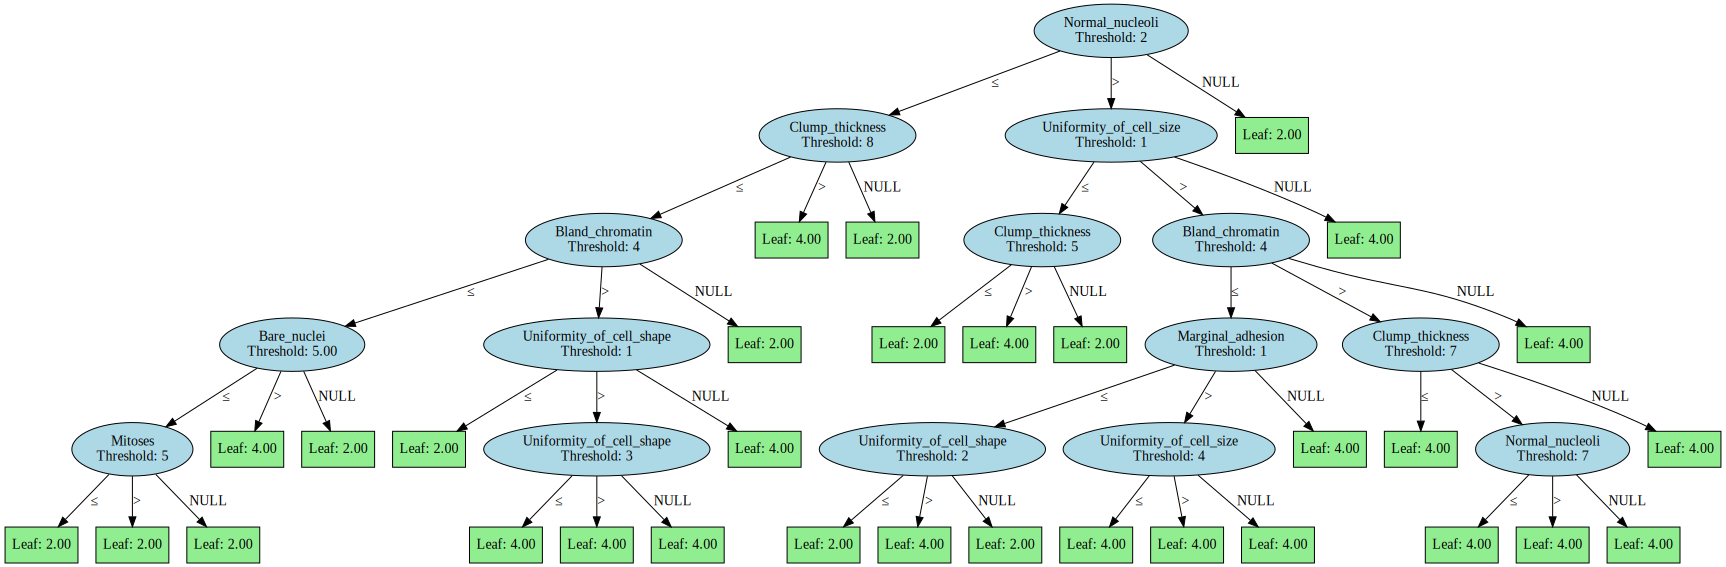

In [26]:
treeView = rf_custom.trees[11].tree
graph = visualize_tree(treeView, X_train)

# Guardem a drive
folder_path = '/content/drive/MyDrive/TFG/Trees'
# path
filepath = os.path.join(folder_path, 'tree11')
# Guarda PNG
graph.render(filename=filepath, format='png', cleanup=True)

graph

# DATASET IMPUTAT AMB Fillna()

In [27]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

#  Substitueix valors especials per NaN
Xdata.replace(['?', -1, 'unknown', 'Unknown', ''], np.nan, inplace=True)

#  Imputació de valors nuls amb la mitjana de cada columna numèrica
Xdata_imputed = Xdata.copy()
for col in Xdata_imputed.columns:
    if Xdata_imputed[col].dtype in ['float64', 'int64']:
        Xdata_imputed[col] = Xdata_imputed[col].fillna(Xdata_imputed[col].mean())

#  Divisió en train i test amb dades imputades
X_train, X_test, y_train, y_test = train_test_split(Xdata_imputed, ydata, test_size=0.2, random_state=42, stratify=ydata)

print("🔍 X_test shape:", X_test.shape)
print("🔍 y_test shape:", y_test.shape)


#  Entrenar el model amb Random Forest personalitzat
rf_custom = RandomForest(n_trees=20, max_depth=5, max_features=5)
rf_custom.fit(X_train, y_train)

#  Predir amb el Random Forest personalitzat
start_time = time.time()

y_pred_custom = rf_custom.predict(X_test)
time_custom = time.time() - start_time

#  Validació de resultats
print("\n Predicció del model:")
print(f"Tipus: {type(y_pred_custom)}")
print(f"Forma: {y_pred_custom.shape}")
print(f"Primers valors: {y_pred_custom[:10].values if isinstance(y_pred_custom, pd.Series) else y_pred_custom[:10]}")
print(f" Temps de predicció: {time_custom:.4f} s")

#  Avaluació amb múltiples mètriques
print("\n Mètriques de classificació:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_custom):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_custom, average='macro'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_custom, average='macro'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_custom, average='macro'):.4f}")

print("\n Matriu de confusió:")
print(confusion_matrix(y_test, y_pred_custom))

print("\n Informe de classificació:")
print(classification_report(y_test, y_pred_custom))

<ipython-input-27-a2fb3dbd3602>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xdata.replace(['?', -1, 'unknown', 'Unknown', ''], np.nan, inplace=True)


🔍 X_test shape: (140, 9)
🔍 y_test shape: (140, 1)

 Predicció del model:
Tipus: <class 'pandas.core.series.Series'>
Forma: (140,)
Primers valors: [4. 2. 4. 2. 4. 4. 2. 2. 2. 2.]
 Temps de predicció: 0.2609 s

 Mètriques de classificació:
Accuracy: 0.9429
Precision: 0.9366
Recall: 0.9366
F1 Score: 0.9366

 Matriu de confusió:
[[88  4]
 [ 4 44]]

 Informe de classificació:
              precision    recall  f1-score   support

           2       0.96      0.96      0.96        92
           4       0.92      0.92      0.92        48

    accuracy                           0.94       140
   macro avg       0.94      0.94      0.94       140
weighted avg       0.94      0.94      0.94       140



# CROSS VALIDATION

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Configuració de cross-validation
k = 10  # pots provar amb 5 o 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Guardem mètriques de cada fold
accuracies = []
precisions = []
recalls = []
f1s = []

for fold, (train_index, val_index) in enumerate(kf.split(Xdata)):
    print(f"\nFold {fold + 1}/{k}")

    X_train, X_val = Xdata.iloc[train_index], Xdata.iloc[val_index]
    y_train, y_val = ydata.iloc[train_index], ydata.iloc[val_index]

    # oversampling aqui

    rf_custom = RandomForest(n_trees=20, max_depth=5, max_features=5)
    rf_custom.fit(X_train, y_train)

    y_pred = rf_custom.predict(X_val)

    # Mètriques
    accuracies.append(accuracy_score(y_val, y_pred))
    precisions.append(precision_score(y_val, y_pred, average='macro'))
    recalls.append(recall_score(y_val, y_pred, average='macro'))
    f1s.append(f1_score(y_val, y_pred, average='macro'))

# Resultats mitjans
print("\n Mitjanes Cross-Validation:")
print(f"Accuracy: {np.mean(accuracies):.4f}")
print(f"Precision (macro): {np.mean(precisions):.4f}")
print(f"Recall (macro): {np.mean(recalls):.4f}")
print(f"F1 Score (macro): {np.mean(f1s):.4f}")


🔁 Fold 1/10

🔁 Fold 2/10

🔁 Fold 3/10

🔁 Fold 4/10

🔁 Fold 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔁 Fold 6/10

🔁 Fold 7/10

🔁 Fold 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔁 Fold 9/10

🔁 Fold 10/10

📊 Mitjanes Cross-Validation:
Accuracy: 0.9850
Precision (macro): 0.9209
Recall (macro): 0.9239
F1 Score (macro): 0.9218


# XGBoost Test

In [30]:

import xgboost as xgb

# Substitueix valors especials per NaN
Xdata.replace(['?', -1, 'unknown', 'Unknown', ''], np.nan, inplace=True)
ydata = ydata.replace({2: 0, 4: 1}) #xgboost espera 0,1 ---> Pel Breast Cancer Wisconsin
# Divisió en train i test
#Amb stratify mantenim prorporcio de la clase en test i train
X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata, test_size=0.2, random_state=42, stratify=ydata)
print(" X_test shape:", X_test.shape)
print(" y_test shape:", y_test.shape)

#  Entrenar el model amb XGBoost
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    n_estimators=20,
    max_depth=5,
    learning_rate=0.1,
    eval_metric='mlogloss',
    random_state=42
)
xgb_clf.fit(X_train, y_train)

#  Predir amb XGBoost
start_time = time.time()
y_pred_xgb = xgb_clf.predict(X_test)
time_xgb = time.time() - start_time

# Validació de resultats
print("\n Predicció amb XGBoost:")
print(f"Tipus: {type(y_pred_xgb)}")
print(f"Forma: {y_pred_xgb.shape}")
print(f"Primers valors: {y_pred_xgb[:10]}")
print(f" Temps de predicció: {time_xgb:.4f} s")

#  Avaluació amb múltiples mètriques
print("\n Mètriques de classificació:")

print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb, average='macro'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb, average='macro'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb, average='macro'):.4f}")

print("\n Matriu de confusió:")
print(confusion_matrix(y_test, y_pred_xgb))

#  Resum complet per classe
print("\n Informe de classificació:")
print(classification_report(y_test, y_pred_xgb))

<ipython-input-30-7bdec2e862a3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xdata.replace(['?', -1, 'unknown', 'Unknown', ''], np.nan, inplace=True)


 X_test shape: (140, 9)
 y_test shape: (140, 1)

 Predicció amb XGBoost:
Tipus: <class 'numpy.ndarray'>
Forma: (140,)
Primers valors: [1 0 0 0 1 1 0 0 0 0]
 Temps de predicció: 0.0265 s

 Mètriques de classificació:
Accuracy: 0.9429
Precision: 0.9408
Recall: 0.9316
F1 Score: 0.9359

 Matriu de confusió:
[[89  3]
 [ 5 43]]

 Informe de classificació:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        92
           1       0.93      0.90      0.91        48

    accuracy                           0.94       140
   macro avg       0.94      0.93      0.94       140
weighted avg       0.94      0.94      0.94       140



# LightGBM Test

In [31]:
import lightgbm as lgb

# Substitueix valors especials per NaN
Xdata.replace(['?', -1, 'unknown', 'Unknown', ''], np.nan, inplace=True)

# Divisió en train i test
#Amb stratify mantenim prorporcio de la clase en test i train
X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata, test_size=0.2, random_state=42, stratify=ydata)
print("🔍 X_test shape:", X_test.shape)
print("🔍 y_test shape:", y_test.shape)


# Entrenar el model amb LightGBM
lgbm_clf = lgb.LGBMClassifier(
    n_estimators=20,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

lgbm_clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='logloss',
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

# Predir amb LightGBM
start_time = time.time()
y_pred_lgbm = lgbm_clf.predict(X_test)
time_lgbm = time.time() - start_time

# Validació de resultats
print("\n Predicció amb LightGBM:")
print(f"Tipus: {type(y_pred_lgbm)}")
print(f"Forma: {y_pred_lgbm.shape}")
print(f"Primers valors: {y_pred_lgbm[:10]}")
print(f" Temps de predicció: {time_lgbm:.4f} s")

# Avaluació amb múltiples mètriques
print("\n Mètriques de classificació:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgbm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lgbm, average='macro'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lgbm, average='macro'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lgbm, average='macro'):.4f}")

print("\n Matriu de confusió:")
print(confusion_matrix(y_test, y_pred_lgbm))

# Resum complet per classe
print("\n Informe de classificació:")
print(classification_report(y_test, y_pred_lgbm))

🔍 X_test shape: (140, 9)
🔍 y_test shape: (140, 1)
[LightGBM] [Info] Number of positive: 193, number of negative: 366
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 97
[LightGBM] [Info] Number of data points in the train set: 559, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345259 -> initscore=-0.639943
[LightGBM] [Info] Start training from score -0.639943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

<ipython-input-31-abb22a66131d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xdata.replace(['?', -1, 'unknown', 'Unknown', ''], np.nan, inplace=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A